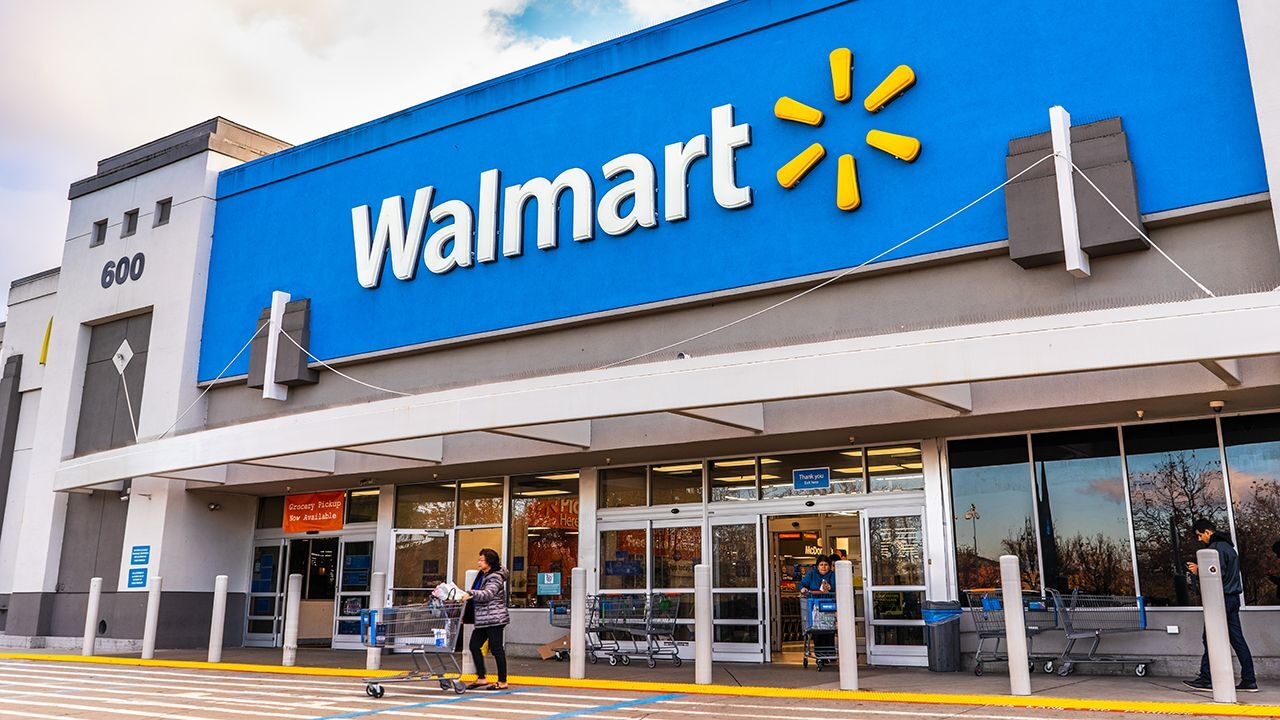

Stores :
Store: The store number. Range from 1–45.
Type: Three types of stores ‘A’, ‘B’ or ‘C’.
Size: Sets the size of a Store would be calculated by the no. of products available in the particular store ranging from 34,000 to 210,000.

Features:
Temperature: Temperature of the region during that week.
Fuel_Price: Fuel Price in that region during that week.
MarkDown1:5 : Represents the Type of markdown.
CPI: Consumer Price Index during that week.
Unemployment: The unemployment rate during that week in the region of the store.

Sales:
Date: The date of the week where this observation was taken.
Weekly_Sales: The sales recorded during that Week.
Dept: One of 1–99 that shows the department.
IsHoliday: a Boolean value representing a holiday week or not.

# Step -1 

##### EDA (Exploratory Data Analysis)

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose

In [145]:
# Lets read all the csvs

sales = pd.read_csv('./datsets/2296_3883_compressed_sales data-set.csv.zip')
stores = pd.read_csv('./datsets/datasets_2296_3883_stores data-set.csv')
features = pd.read_csv('./datsets/datasets_2296_3883_Features data set.csv')

In [146]:
# Lets merge the Sales and Stores Csv first.

retail_data = pd.merge(sales,stores,on=['Store'],how='left')

In [147]:
# lets merge the features csv with other files.

retail_data = pd.merge(retail_data,features,on=['Store','Date','IsHoliday'],how='left')

In [148]:
# lets check the first few rows of the new dataframe
retail_data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,05/02/2010,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,12/02/2010,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106


In [149]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [150]:
# Lets check the columns 

retail_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')

In [151]:
# Lets check the null values 

retail_data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

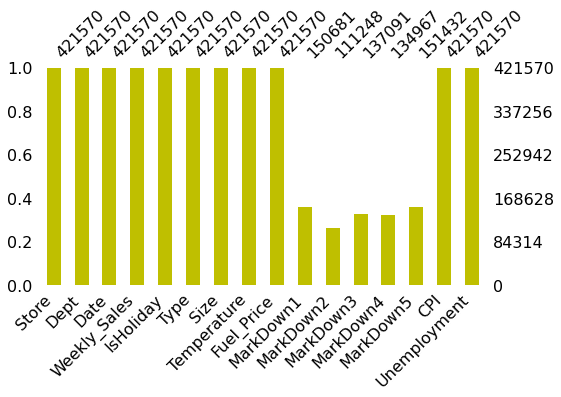

In [152]:
# Lets visiuale the missing Values

import missingno as msno

msno.bar(retail_data,figsize=(8, 4),color='y')

In [153]:
#missing data percentage

total = retail_data.isnull().sum().sort_values(ascending=False)
percent = (retail_data.isnull().sum()/retail_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20).T

,MarkDown2,MarkDown4,MarkDown3,MarkDown1,MarkDown5,Unemployment,CPI,Fuel_Price,Temperature,Size,Type,IsHoliday,Weekly_Sales,Date,Dept,Store
Total,310322.00000,286603.000000,284479.000000,270889.000000,270138.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.73611,0.679847,0.674808,0.642572,0.64079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<BarContainer object of 16 artists>

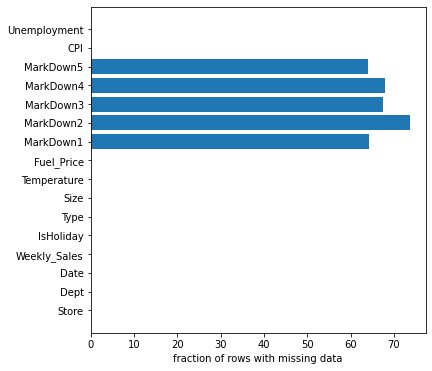

In [154]:
# Distribution of NaNs for all columns

features_missing = retail_data.isna().sum()/len(retail_data) * 100

#Visualize
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

In [155]:
# lets inspect the IsHoliday column

retail_data.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

In [156]:
# Lets create a dummies for IsHoliday column

retail_data = pd.get_dummies(retail_data,columns=['IsHoliday'])

In [157]:
# Lets describe

retail_data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_False,IsHoliday_True
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,0.929642,0.070358
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,0.255750,0.255750
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,0.000000,0.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,1.000000,0.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,1.000000,0.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,1.000000,0.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,1.000000,1.000000


In [158]:
# Lets check for negative sales

retail_data[retail_data.Weekly_Sales < 0].describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_False,IsHoliday_True
count,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,481.000000,330.000000,424.000000,432.000000,484.000000,1285.000000,1285.000000,1285.000000,1285.000000
mean,23.858366,49.999222,-68.608218,129645.725292,59.954078,3.406292,6821.195031,4918.016697,741.035307,2900.351389,4472.117583,167.864301,8.029536,0.923735,0.076265
std,12.033126,24.394330,231.664245,56461.302600,18.346794,0.453768,7745.309031,13652.405534,6361.180096,5470.741542,6850.274900,38.032214,1.662948,0.265524,0.265524
min,1.000000,5.000000,-4988.940000,34875.000000,-2.060000,2.514000,2.120000,-192.000000,-0.200000,0.410000,164.080000,126.064000,4.125000,0.000000,0.000000
25%,15.000000,31.000000,-41.000000,93638.000000,46.650000,2.976000,2095.310000,36.007500,4.965000,516.770000,1730.175000,132.751667,7.057000,1.000000,0.000000
50%,22.000000,47.000000,-13.200000,123737.000000,62.170000,3.506000,5430.750000,211.975000,22.840000,1303.340000,3019.005000,142.017793,8.067000,1.000000,0.000000
75%,35.000000,59.000000,-4.940000,196321.000000,73.400000,3.787000,8708.200000,2101.825000,102.700000,3301.810000,5428.080000,211.006754,8.744000,1.000000,0.000000
max,45.000000,99.000000,-0.020000,219622.000000,95.910000,4.468000,65021.230000,97740.990000,101378.790000,52739.020000,108519.280000,226.968844,14.313000,1.000000,1.000000


In [159]:
# Imputed Missing Markdowns values with 0
retail_data.fillna(value=0,inplace=True)

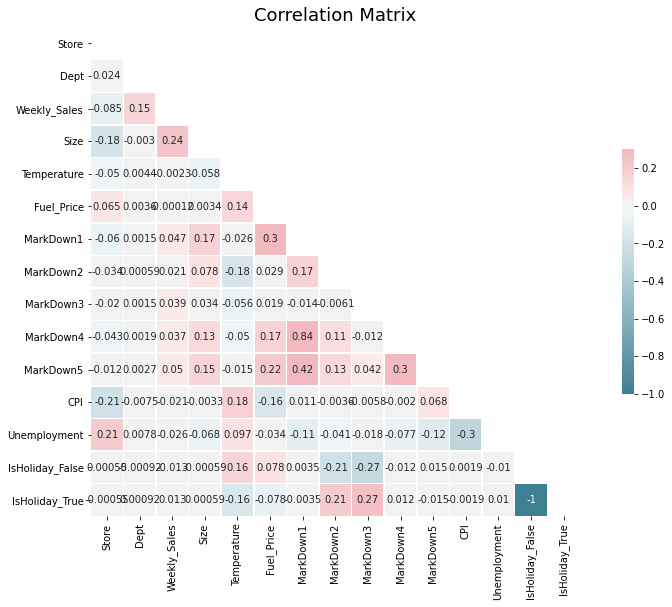

In [160]:
corr = retail_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(15, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [161]:
# Lets create a columns with million values

retail_data['Weekly_sale_in_millions'] = retail_data['Weekly_Sales']/1000000

In [162]:
# Lets also check the typewise count

retail_data.groupby('Type').count()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_False,IsHoliday_True,Weekly_sale_in_millions
Type,,,,,,,,,,,,,,,,,
A,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478,215478
B,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495,163495
C,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597,42597


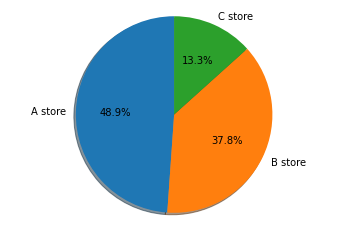

In [163]:
# Lets visualise the typewise contribution of sales

labels = 'A store','B store','C store'
sizes = [(22/(45))*100,(17/(45))*100,(6/(45))*100]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

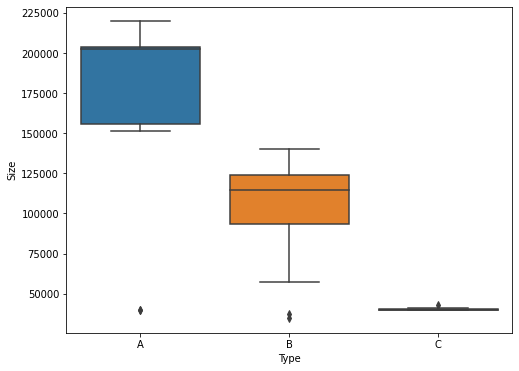

In [164]:
# boxplot for sizes of types of stores
store_type = pd.concat([stores['Type'], stores['Size']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=store_type)

In [165]:
retail_data.groupby('Type')['Weekly_Sales'].sum()

Type
A    4.331015e+09
B    2.000701e+09
C    4.055035e+08
Name: Weekly_Sales, dtype: float64

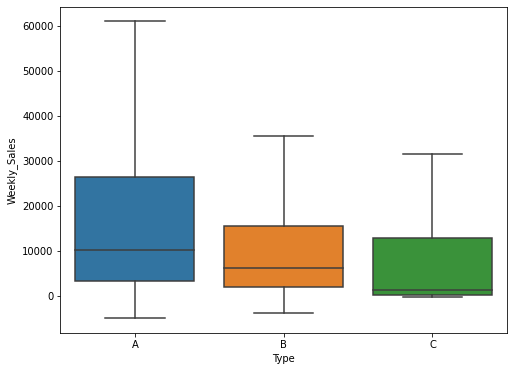

In [166]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=retail_data, showfliers=False)

In [167]:
# Lets make a new date columns


retail_data['new_date'] =  pd.to_datetime(retail_data['Date'])

retail_data = retail_data.set_index(['new_date'])

retail_data.head(2)

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_False,IsHoliday_True,Weekly_sale_in_millions
new_date,,,,,,,,,,,,,,,,,,
2010-05-02,1,1,05/02/2010,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0,0.024924
2010-12-02,1,1,12/02/2010,46039.49,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,1,0.046039


In [168]:
# Lets convert a date column into datetime format

retail_data['Date'] = pd.to_datetime(retail_data['Date'])

In [169]:
# Adding new columns of month , year and dayofweek

retail_data['month'] = retail_data['Date'].dt.strftime('%B')
retail_data['year1'] = retail_data['Date'].dt.strftime('%Y')
retail_data['dayofweek'] = retail_data['Date'].dt.strftime('%A')
retail_data['week'] = retail_data['Date'].dt.week
retail_data['Year'] = retail_data.Date.dt.year

In [170]:
# Lets create a new monthyear column

retail_data['month_year']=retail_data['month'] +retail_data['Year'].astype(str)

Text(0, 0.5, 'Weekly_Sales')

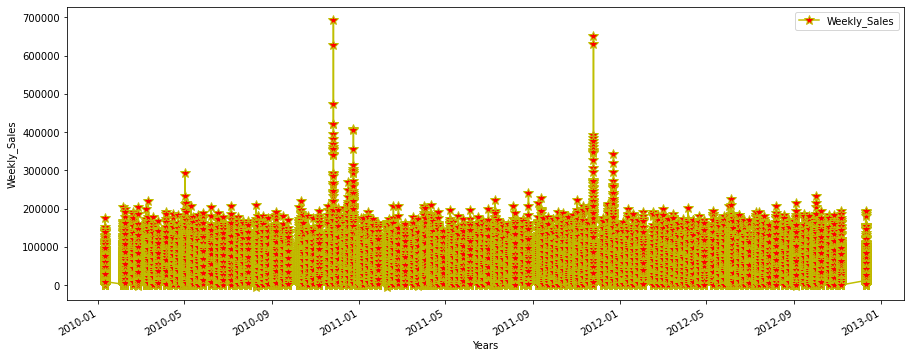

In [171]:
# Lets visualise the month wise weekly sale

retail_data.plot(x='Date',y='Weekly_Sales',figsize=(15,6),linestyle='-', marker='*', markerfacecolor='r',color='y',markersize=10)

plt.xlabel('Years')
plt.ylabel('Weekly_Sales')


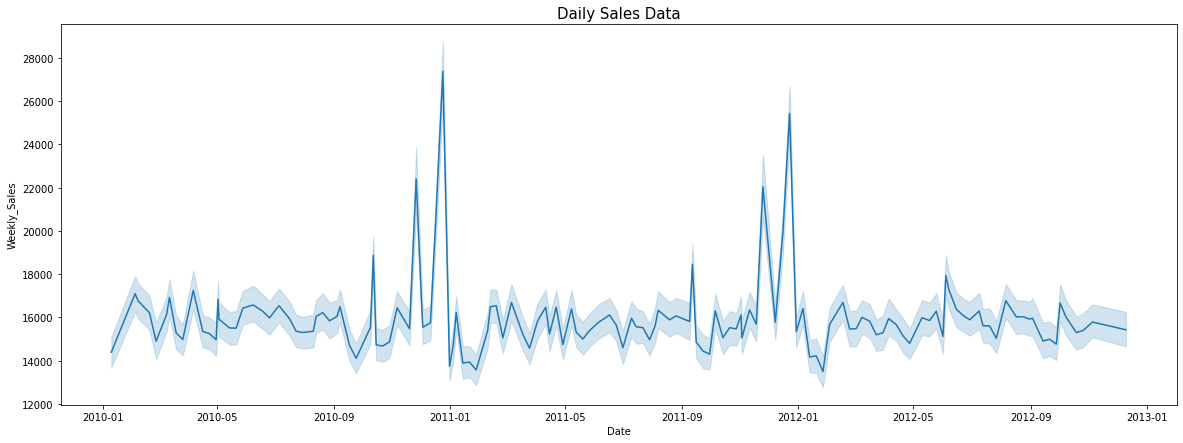

In [172]:
# Lets visualize the datewise weekly sales 

fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Weekly_Sales", data=retail_data)
a.set_title("Daily Sales Data",fontsize=15)
plt.show()

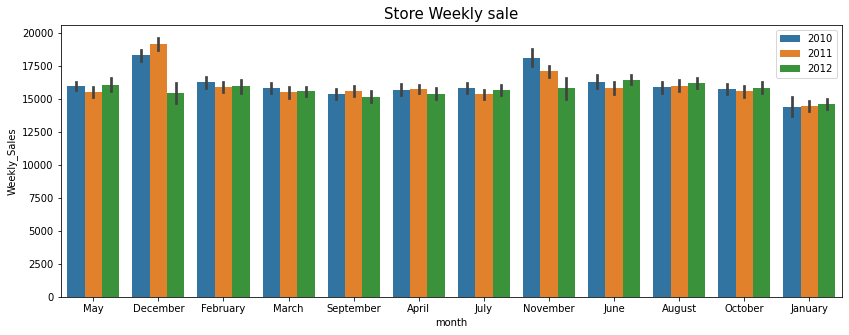

In [173]:
# Lets visualize the monthwise sale 

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Weekly_Sales",hue = 'Year',data=retail_data)
a.set_title("Store Weekly sale",fontsize=15)
plt.legend(loc='upper right')
plt.show()

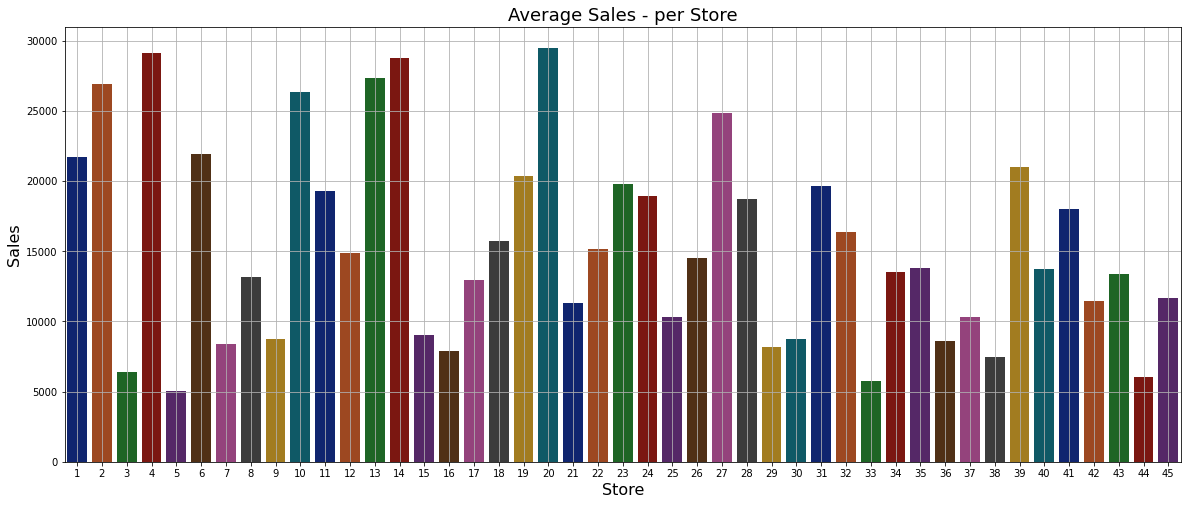

In [174]:
# Storewise Weekly sale

weekly_sales = retail_data['Weekly_Sales'].groupby(retail_data['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

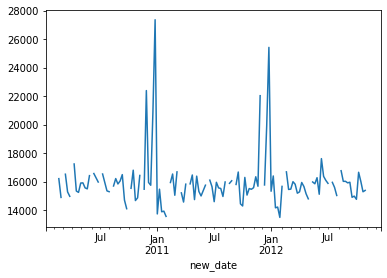

In [175]:
# Checking for the missing values

retail_data.Weekly_Sales.resample('W').mean().plot()

## Creating a new dataframe for timeseries analysis

In [176]:
#Lets resample weekly sales

final_data = retail_data.resample('W').mean().interpolate(method='spline',order=1).drop(['week','Year','Size',
                                                                                      'Dept','Store','CPI',
                                                                                     'Unemployment'],axis=1)

In [177]:
final_data = pd.DataFrame(final_data)

In [178]:
#resetting index
final_data = final_data.reset_index()

In [179]:
# Renaming the columns name as ds for dates  ans y for sales

retail_fbprophet = final_data.rename(columns={'new_date':'ds','Weekly_Sales':'y'})
retail_fbprophet.head()

,ds,y,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday_False,IsHoliday_True,Weekly_sale_in_millions
0,2010-01-10,14391.780535,69.386998,2.733064,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.014392
1,2010-01-17,15027.618704,68.156548,2.746842,-0.000035,3.772133e-07,7.727687e-09,0.000124,0.002065,0.948623,0.051377,0.016030
2,2010-01-24,15663.441309,66.909174,2.755070,-0.000033,3.516864e-07,7.204735e-09,0.000115,0.001925,0.948419,0.051581,0.016029
3,2010-01-31,16299.263913,65.661799,2.763298,-0.000030,3.261594e-07,6.681784e-09,0.000107,0.001786,0.948215,0.051785,0.016028
4,2010-02-07,16935.103266,64.506546,2.809409,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.016935


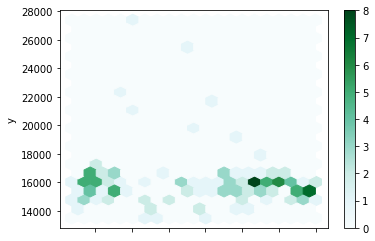

In [180]:
# Lets plot the fuelprice to see the impact on sales

ax = retail_fbprophet.plot.hexbin(x='Fuel_Price', y='y', gridsize=20)

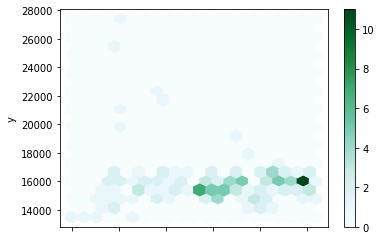

In [181]:
# Lets plot the Temperature  to see the impact on sales

ax = retail_fbprophet.plot.hexbin(x='Temperature', y='y', gridsize=20)

In [182]:
# Lets visualise the intractive lineplot

import plotly.express as px

fig = px.line(retail_fbprophet,x ='ds',y= 'y',hover_data=['Temperature','Fuel_Price'],title='Retail_Weekly_Sales')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1,label='1y',step='year',stepmode='backward'),
            dict(count=2,label='2y',step='year',stepmode='backward'),
            dict(count=3,label='3y',step='year',stepmode='backward'),
            dict(step='all')])))
fig.show()

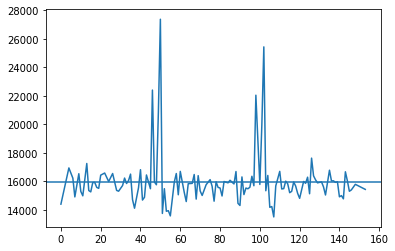

In [183]:
retail_fbprophet['y'].plot()
plt.axhline(retail_fbprophet['y'].mean())
plt.show()

## Differencing To fix the Non Stationary data

In [184]:
# if P value is less than ttest ,reject null hypothesis

In [185]:
# Performed Dickey-Fuller test on full dataset to check weather the data is stationarity or not.- 2nd Technique

from statsmodels.tsa.stattools import adfuller

print('Result of Dicky Fuller  Test:')

dftest = adfuller(retail_fbprophet['y'],autolag='AIC')

dfoutput =pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Result of Dicky Fuller  Test:
Test Statistic                -5.786983e+00
p-value                        4.973017e-07
#Lags Used                     4.000000e+00
Number of observations Used    1.490000e+02
Critical Value (1%)           -3.475018e+00
Critical Value (5%)           -2.881141e+00
Critical Value (10%)          -2.577221e+00
dtype: float64


## Decompose our Dataset

In [186]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

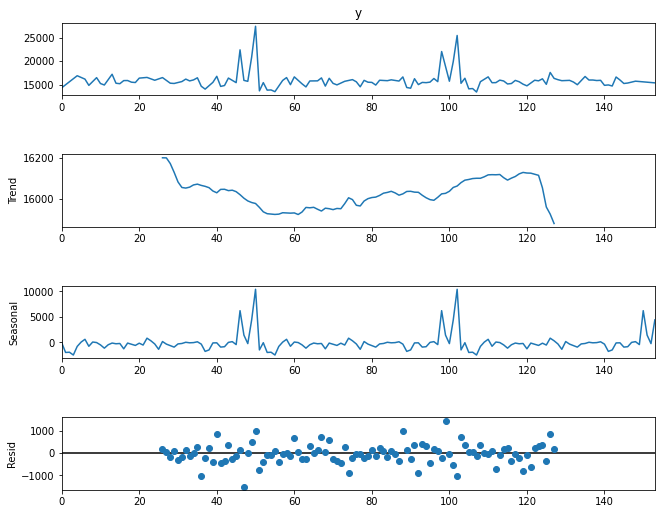

In [187]:
decomposition = seasonal_decompose(retail_fbprophet['y'],period=52,model='Additive')
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

# Creating a two new columns (floor and Cap)

In [188]:
retail_fbprophet['y'].max()

27378.69269282817

In [189]:
# Setting up the floor and cap for logistic hyperparameter in fbprophit .

retail_fbprophet['floor']= 0
retail_fbprophet['cap']= 27378.69269282817

In [190]:
retail_fbprophet.tail()

,ds,y,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday_False,IsHoliday_True,Weekly_sale_in_millions,floor,cap
149,2012-11-18,15712.720782,62.738548,3.964586,8401.065565,7.230725,50.664829,1788.329908,3509.605699,0.918494,0.081506,0.015887,0,27378.692693
150,2012-11-25,15641.440608,61.476435,3.972814,6789.597731,5.423036,42.190731,1480.539672,4034.654946,0.918291,0.081709,0.015886,0,27378.692693
151,2012-12-02,15570.160434,60.214322,3.981042,5178.129897,3.615346,33.716633,1172.749437,4559.704194,0.918087,0.081913,0.015885,0,27378.692693
152,2012-12-09,15498.880260,58.952209,3.989270,3566.662063,1.807657,25.242536,864.959201,5084.753441,0.917884,0.082116,0.015884,0,27378.692693
153,2012-12-16,15427.596739,57.687284,3.897425,1955.152860,0.000000,16.768415,557.157512,5609.802120,1.000000,0.000000,0.015428,0,27378.692693


# Train Test Split - Fb prophet

In [191]:
# Train Test Split

from sklearn.model_selection import train_test_split

In [192]:
# Making targets and Predictors

train_data = retail_fbprophet.loc[retail_fbprophet.ds <= '2012-05-27' , :]
test_data = retail_fbprophet.loc[retail_fbprophet.ds > '2012-05-27' , :]

# X_train = train_data['y(t-1)']
# y_train = train_data['y2(t+1)']

# X_test = test_data['y(t-1)']
# y_test = test_data['y2(t+1)']

In [193]:
# Lets check the shape

train_data.shape , test_data.shape

((125, 14), (29, 14))

## Calculating the base error

In [194]:
# Create lagged dataset for base score

retail_fbprophet['y(t-1)'] =  retail_fbprophet['y'].shift(1)
retail_fbprophet['y2(t+1)'] = retail_fbprophet['y']

In [195]:
retail_fbprophet.head(2)

,ds,y,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday_False,IsHoliday_True,Weekly_sale_in_millions,floor,cap,y(t-1),y2(t+1)
0,2010-01-10,14391.780535,69.386998,2.733064,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.014392,0,27378.692693,NaN,14391.780535
1,2010-01-17,15027.618704,68.156548,2.746842,-0.000035,3.772133e-07,7.727687e-09,0.000124,0.002065,0.948623,0.051377,0.016030,0,27378.692693,14391.780535,15027.618704


In [196]:
retail_fbprophet.dropna(inplace=True)

In [197]:
# # Setting up X and Y for base score
X = retail_fbprophet['y(t-1)']
y = retail_fbprophet['y2(t+1)']

In [198]:
X.shape,y.shape

((153,), (153,))

In [199]:
# Lets drop the Nans
retail_fbprophet.dropna(inplace=True)

In [200]:
X.shape,y.shape

((153,), (153,))

In [201]:
# # persistence model
def model_persistence(x):
    return x

In [202]:
# walk-forward validation
predictions = list()
for x in X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(y, predictions)
print('Test base score (MSE): %.3f' % test_score)

Test base score (MSE): 4308946.679


In [203]:
# Base RMSE

rmse = np.sqrt(test_score)
rmse

2075.8002503736625

# Model -1

## Initializing the Model - FB Prophet

######  A multiplicative decomposition roughly corresponds to an additive decomposition of the logarithms. The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. 

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.

In [204]:
from fbprophet import Prophet

In [205]:
retail_fbprophet.head(2)

,ds,y,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday_False,IsHoliday_True,Weekly_sale_in_millions,floor,cap,y(t-1),y2(t+1)
1,2010-01-17,15027.618704,68.156548,2.746842,-0.000035,3.772133e-07,7.727687e-09,0.000124,0.002065,0.948623,0.051377,0.016030,0,27378.692693,14391.780535,15027.618704
2,2010-01-24,15663.441309,66.909174,2.755070,-0.000033,3.516864e-07,7.204735e-09,0.000115,0.001925,0.948419,0.051581,0.016029,0,27378.692693,15027.618704,15663.441309


# Calculating Error Metrics for Model

In [206]:
### initializing the Model for calculating the model RMSE 

model = Prophet(growth='logistic',
                    holidays_prior_scale = 2,
                      n_changepoints = 5,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = False,
                      yearly_seasonality = True,
                      interval_width=0.95)
model.add_country_holidays(country_name='US')
model.add_regressor('Temperature',standardize=True)
model.add_regressor('Fuel_Price',standardize=True)
model.add_regressor('MarkDown1',standardize=True)
model.add_regressor('MarkDown2',standardize=True)
model.add_regressor('MarkDown3',standardize=True)
model.add_regressor('MarkDown4',standardize=True)
model.add_regressor('MarkDown5',standardize=True)
model.add_regressor('IsHoliday_True',standardize=True)

In [207]:
model.fit(retail_fbprophet)

In [208]:
predicted = model.predict(retail_fbprophet)

In [209]:
# My model predticed RMSE

mse = mean_squared_error(retail_fbprophet['y'],predicted['yhat'])
print('RMSE:', np.sqrt(mse))

RMSE: 1087.4390671401425


In [210]:
# Lets initialise and fit the model

model_1 = Prophet(growth='logistic',
                    holidays_prior_scale = 2,
                      n_changepoints = 5,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = False,
                      yearly_seasonality = True,
                      interval_width=0.95)
model_1.add_country_holidays(country_name='US')
model_1.add_regressor('Temperature',standardize=True)
model_1.add_regressor('Fuel_Price',standardize=True)
model_1.add_regressor('MarkDown1',standardize=True)
model_1.add_regressor('MarkDown2',standardize=True)
model_1.add_regressor('MarkDown3',standardize=True)
model_1.add_regressor('MarkDown4',standardize=True)
model_1.add_regressor('MarkDown5',standardize=True)
model_1.add_regressor('IsHoliday_True',standardize=True)

In [211]:
model_1.fit(train_data)

In [212]:
model.params

OrderedDict([('k', array([[-0.08070365]])),
             ('m', array([[-3.30292006]])),
             ('delta',
              array([[-3.41233178e-08,  1.53760179e-10,  3.88256887e-09,
                       1.26835669e-08, -5.60972434e-07]])),
             ('sigma_obs', array([[0.04031294]])),
             ('beta',
              array([[-1.07408692e-02,  2.77987495e-02, -2.67387864e-02,
                       4.61951454e-02, -3.32839678e-02,  2.76958944e-02,
                      -4.27968343e-02,  1.55550853e-02, -2.25401156e-02,
                       2.27458188e-02, -4.66399955e-02,  2.86742042e-02,
                      -2.97923335e-02,  2.37485652e-02, -1.38605791e-02,
                       2.26853851e-02, -2.24149215e-02,  2.94515667e-02,
                      -2.65686878e-02,  1.89112658e-02,  5.47730901e-02,
                      -1.13737493e-01, -9.86976979e-02,  7.87087876e-02,
                       1.23074016e-01, -2.80908411e-02,  0.00000000e+00,
                       4.5

In [213]:
# Lets mnake future dates now

future_dates = model_1.make_future_dataframe(periods=52,freq='W')

In [214]:
# Lets also add following new columns for future dates
future_dates['floor']=0
future_dates['cap']=27378.692693

In [215]:
pd.set_option('max_rows', 2000)
pd.set_option('max_columns', 300)
mode1 = round(retail_fbprophet.Temperature.mode())

In [216]:
# Lets also add Temp and fuel column for future dates,

future_dates['Temperature']= 79
future_dates['Fuel_Price']= 3.5

In [217]:
# Lets also add Markdowns for future dates

future_dates['MarkDown1'] = 0.0
future_dates['MarkDown2'] = 0
future_dates['MarkDown3'] =0
future_dates['MarkDown4']=0
future_dates['MarkDown5']=0
future_dates['IsHoliday_True'] = 0

# Actual Vs Predictions and Forecasting

In [219]:
# Predictions on forcasting

yhat_for_future_dates = model_1.predict(future_dates)

yhat_for_future_dates[['ds','yhat','yhat_lower','yhat_upper','Temperature','Fuel_Price']].tail()


,ds,yhat,yhat_lower,yhat_upper,Temperature,Fuel_Price
172,2013-04-28,14653.549481,12414.607054,16892.847717,0.004109,0.00225
173,2013-05-05,14467.314008,12218.350086,16593.461988,0.004109,0.00225
174,2013-05-12,14657.210687,12342.007250,16853.130886,0.004109,0.00225
175,2013-05-19,14964.975563,12695.084894,17193.854720,0.004109,0.00225
176,2013-05-26,15053.429493,12887.864922,17372.141337,0.004109,0.00225


In [220]:
predictions = model_1.predict(retail_fbprophet)

In [221]:
retail_fbprophet['prediction']=predictions['yhat']

In [142]:
import plotly.express as px
import plotly.graph_objects as go

In [222]:
import plotly.express as px

fig = px.line(new,x ='ds',y= 'yhat',hover_data=['yhat_lower','yhat_upper','Temperature','Fuel_Price'],title='Datwise prediction')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1,label='1y',step='year',stepmode='backward'),
            dict(count=2,label='2y',step='year',stepmode='backward'),
            dict(count=3,label='3y',step='year',stepmode='backward'),
            dict(step='all')])))
fig.show()

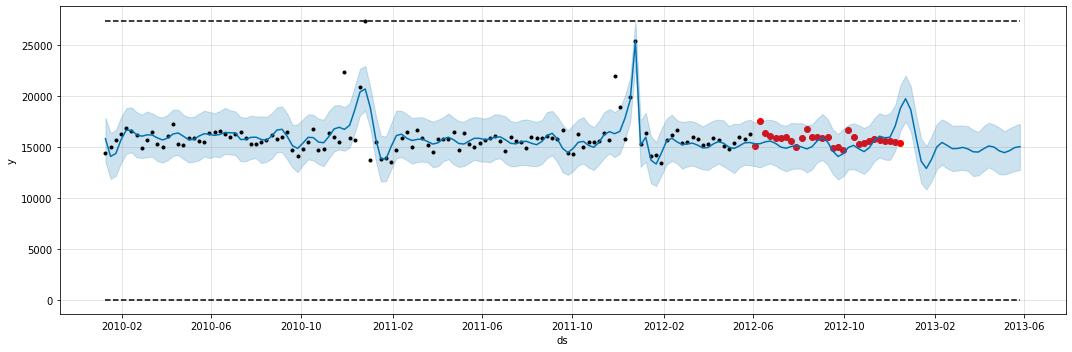

In [96]:
# Plot the predticted with the actuals

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_data.ds,test_data['y'], color='r')
fig = model_1.plot(yhat_for_future_dates, ax=ax)

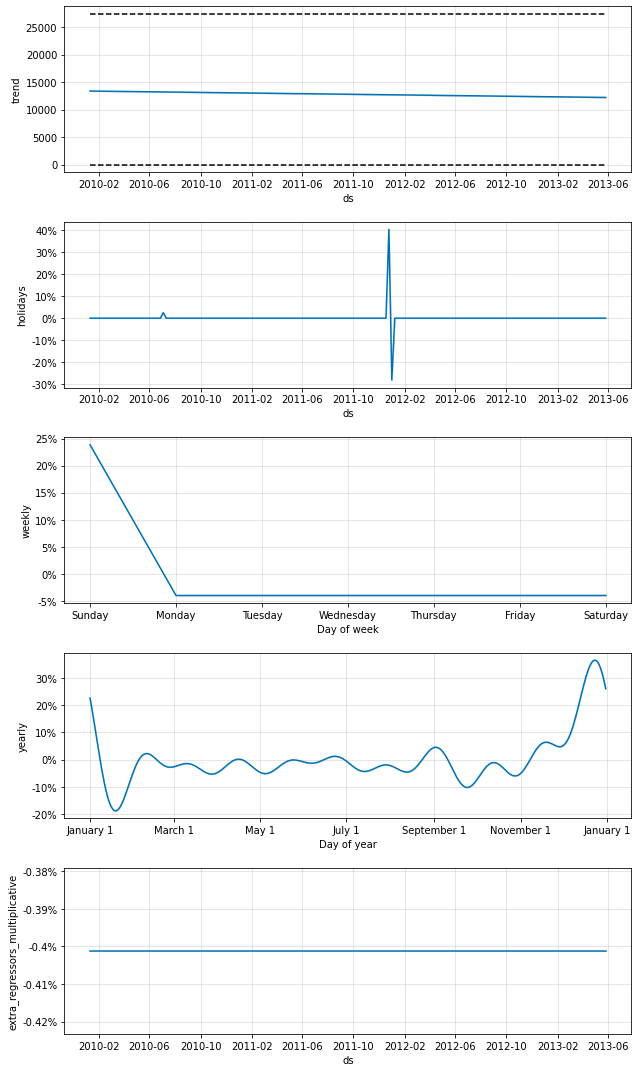

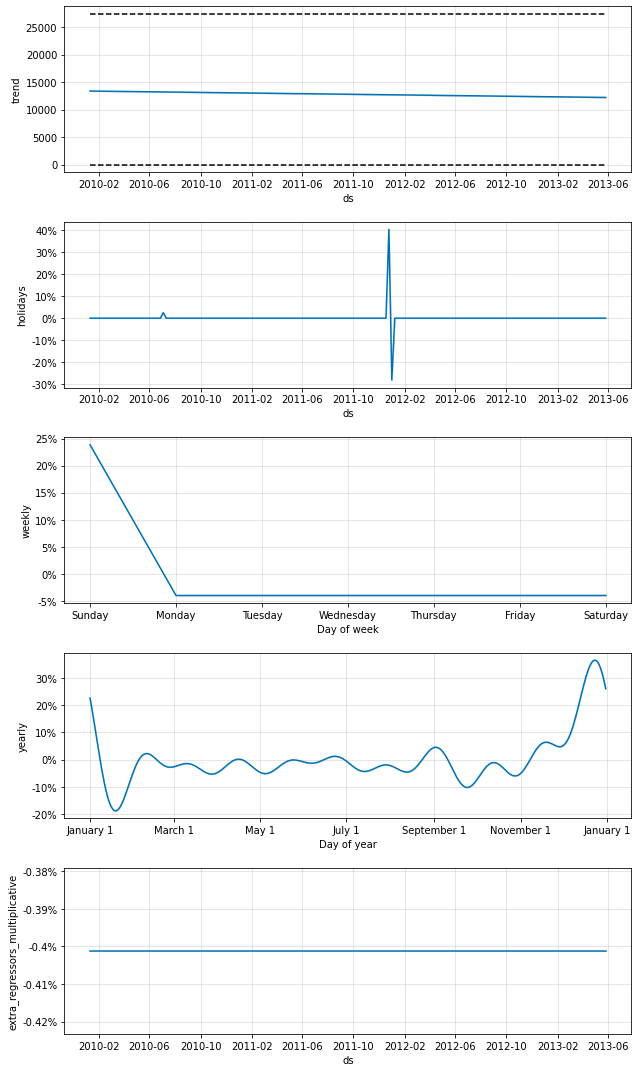

In [97]:
# Visualize each component weekly and yearlywise - on actual predictions data

model_1.plot_components(yhat_for_future_dates)

##  Calculating Error Metrics

In [98]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from math import sqrt

In [99]:
# Base RMSE

rmse = np.sqrt(test_score)
rmse

2075.8002503736625

In [100]:
# My model predticed RMSE

mse = mean_squared_error(retail_fbprophet['y'],predicted['yhat'])
print('RMSE:', np.sqrt(mse))

RMSE: 1087.4390671401425


In [101]:
1088.7695897957728/2075.8002503736625

0.5245059535953831

## Cross Validation

In [227]:
from fbprophet.diagnostics import cross_validation

In [228]:
# Lets check the shape

retail_fbprophet.shape

(153, 17)

In [229]:
# lets validate the model

df_cv = cross_validation(model_1, horizon ='60 days',period='30 days', initial='180 days')

INFO:fbprophet:Making 21 forecasts with cutoffs between 2010-08-06 00:00:00 and 2012-03-28 00:00:00


In [230]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-08-08,-8838.767764,-9261.372727,-8371.251708,15500.502531,2010-08-06
1,2010-08-15,-103019.533329,-103484.141628,-102620.412800,15700.856077,2010-08-06
2,2010-08-22,-305379.358329,-305771.484688,-304909.632575,16222.320896,2010-08-06
3,2010-08-29,-574676.581415,-575118.131937,-574259.228014,15841.870407,2010-08-06
4,2010-09-05,-770329.016352,-770759.166431,-769892.234953,16050.589780,2010-08-06
5,2010-09-12,-717030.209772,-717507.174326,-716595.235414,16500.010117,2010-08-06
6,2010-09-19,-359009.648212,-359437.947806,-358574.147086,14708.339539,2010-08-06
7,2010-09-26,160847.454960,160410.161584,161295.122527,14105.905324,2010-08-06
8,2010-10-03,547675.503103,547251.194922,548104.561283,14821.960076,2010-08-06
9,2010-09-12,16454.390297,16096.258818,16803.135789,16500.010117,2010-09-05


## Performance Metrics

In [107]:
from fbprophet.diagnostics import performance_metrics

In [231]:
# Lets create a performance Metrics

df_perfomance = performance_metrics(df_cv)
df_perfomance.head()

NameError: name 'performance_metrics' is not defined

## Visualizing Performance Metrics

In [ ]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv,metric='rmse')